In [31]:
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [32]:
results_dir = Path("results")

SYSTEM_SIDE = 4
FILE_SUFFIX = "many"

TARGET_SEEDS = {42, 43, 44}

In [33]:
def parse_seed_ts(path: Path):
    s_match = re.search(r"seed(\d+)", path.name)
    t_match = re.search(r"(\d{8}_\d{6})", path.name)
    if not (s_match and t_match):
        return None
    return int(s_match.group(1)), t_match.group(1)


def pick_newest_per_seed(glob_pattern: str, target_seeds: set[int]):
    files = list(results_dir.glob(glob_pattern))
    parsed = []

    for p in files:
        out = parse_seed_ts(p)
        if out is None:
            continue
        seed, ts = out
        parsed.append({"seed": seed, "ts": ts, "path": p})

    parsed.sort(key=lambda x: x["ts"], reverse=True)

    selected = {}
    for item in parsed:
        s = item["seed"]
        if s in target_seeds and s not in selected:
            selected[s] = item["path"]

    return [selected[s] for s in sorted(selected.keys())]

In [34]:
glob_pat = f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_magnet_{FILE_SUFFIX}_rbm_seed*_*.csv"
selected_paths = pick_newest_per_seed(glob_pat, TARGET_SEEDS)

print(f"Pattern: {glob_pat}")
print(f"Found {len(selected_paths)} files (newest per seed):")
for p in selected_paths:
    print(f"  - {p.name}")

Pattern: tfim_4x4_magnet_many_rbm_seed*_*.csv
Found 3 files (newest per seed):
  - tfim_4x4_magnet_many_rbm_seed42_20260208_001013.csv
  - tfim_4x4_magnet_many_rbm_seed43_20260208_001015.csv
  - tfim_4x4_magnet_many_rbm_seed44_20260208_001014.csv


In [35]:
dfs = []
seeds = []

for p in selected_paths:
    seed, _ = parse_seed_ts(p)
    df = pd.read_csv(p)
    dfs.append(df)
    seeds.append(np.full(len(df), seed, dtype=int))

all_df = pd.concat(dfs, ignore_index=True)

all_df["seed"] = np.concatenate(seeds)

all_df = all_df[["seed", "h", "type", "mag_z", "mag_x"]].copy()
all_df["type"] = all_df["type"].astype(str)
all_df["seed"] = all_df["seed"].astype(int)
all_df["h"] = all_df["h"].astype(float)
all_df["mag_z"] = all_df["mag_z"].astype(float)
all_df["mag_x"] = all_df["mag_x"].astype(float)

print(f"Seeds used: {sorted(all_df['seed'].unique())}")

Seeds used: [42, 43, 44]


In [36]:
agg_df = (
    all_df
    .groupby("h", as_index=False, observed=True)
    .agg(
        type=("type", "first"),
        mag_z=("mag_z", "median"),
        mag_x=("mag_x", "median"),
        mag_z_err=("mag_z", lambda x: x.std(ddof=0)),
        mag_x_err=("mag_x", lambda x: x.std(ddof=0)),
        n=("seed", "count"),
    )
    .sort_values("h")
)

agg_df.head()

,h,type,mag_z,mag_x,mag_z_err,mag_x_err,n
0,1.0,support,0.967375,0.252999,0.000514,0.002303,3
1,1.5,novel,0.928875,0.367109,0.001300,0.004548,3
2,1.8,novel,0.888125,0.453778,0.003735,0.007878,3
3,2.0,support,0.837750,0.534945,0.004959,0.005980,3
4,2.2,novel,0.789000,0.605496,0.006227,0.006055,3


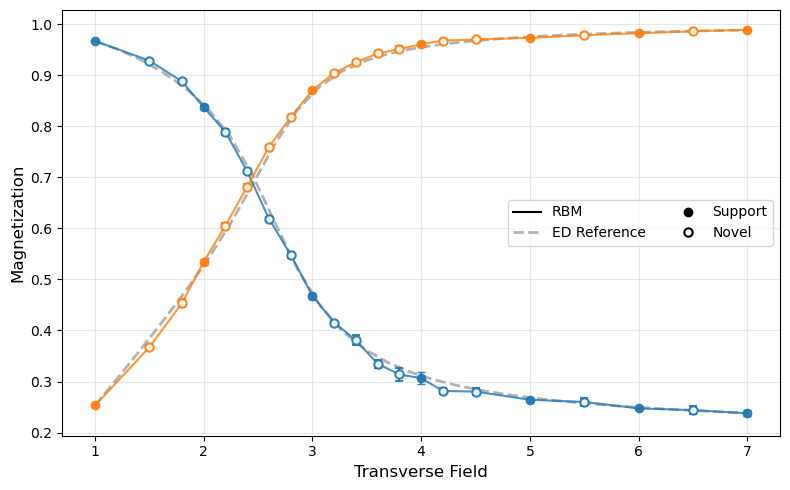

In [37]:
ref_file = Path(f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_magnet_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

plt.figure(figsize=(8, 5), dpi=100)

cmap = plt.get_cmap("tab10")
c_z = cmap(0)
c_x = cmap(1)

if ref_df is not None and {"h", "mag_z", "mag_x"}.issubset(ref_df.columns):
    plt.plot(ref_df["h"], ref_df["mag_z"], "--", color="gray", linewidth=2, alpha=0.6, zorder=0)
    plt.plot(ref_df["h"], ref_df["mag_x"], "--", color="gray", linewidth=2, alpha=0.6, zorder=0)

alpha_line = 0.80

plt.plot(agg_df["h"], agg_df["mag_z"], "-", color=c_z, linewidth=1.5, alpha=alpha_line, zorder=5)
plt.plot(agg_df["h"], agg_df["mag_x"], "-", color=c_x, linewidth=1.5, alpha=alpha_line, zorder=5)

supp = agg_df[agg_df["type"] == "support"]
nov = agg_df[agg_df["type"] == "novel"]

plt.errorbar(supp["h"], supp["mag_z"], yerr=supp["mag_z_err"], fmt="o",
             color=c_z, markersize=6, capsize=3, alpha=0.9, zorder=6)
plt.errorbar(supp["h"], supp["mag_x"], yerr=supp["mag_x_err"], fmt="o",
             color=c_x, markersize=6, capsize=3, alpha=0.9, zorder=6)

plt.errorbar(nov["h"], nov["mag_z"], yerr=nov["mag_z_err"], fmt="o", color=c_z, markerfacecolor="white",
             markeredgewidth=1.5, markersize=6, capsize=3, alpha=0.9, zorder=6)
plt.errorbar(nov["h"], nov["mag_x"], yerr=nov["mag_x_err"], fmt="o", color=c_x, markerfacecolor="white",
             markeredgewidth=1.5, markersize=6, capsize=3, alpha=0.9, zorder=6)

handles = [
    Line2D([0], [0], color="black", linestyle="-", linewidth=1.5, label="RBM"),
    Line2D([0], [0], color="gray", linestyle="--", linewidth=2, alpha=0.6, label="ED Reference"),
    Line2D([0], [0], color="black", marker="o", linestyle="", label="Support"),
    Line2D([0], [0], color="black", marker="o", markerfacecolor="white",
           markeredgewidth=1.5, linestyle="", label="Novel"),
]

plt.xlabel("Transverse Field", fontsize=12)
plt.ylabel("Magnetization", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(handles=handles, loc="best", ncol=2)
plt.tight_layout()
plt.show()

In [38]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = results_dir / (f"tfim_{SYSTEM_SIDE}x{SYSTEM_SIDE}_magnet_{FILE_SUFFIX}_rbm_err_{timestamp}.csv")

out_df = agg_df[["h", "mag_z", "mag_x", "mag_z_err", "mag_x_err"]].copy()
out_df.to_csv(save_path, index=False, float_format="%.6e")

print(f"Saved: {save_path}")

Saved: results/tfim_4x4_magnet_many_rbm_err_20260208_001101.csv
